In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pickle # for .pkl files
import h5py   # for .jld2 files
import os
import torch
from sklearn.decomposition import PCA
import seaborn as sns
from mpl_toolkits.axes_grid1 import ImageGrid


sns.set(style='ticks', palette='Set2', font_scale=1.5, rc={"lines.linewidth": 3})
sns.despine()
# plt.rcParams.update({'font.size': 16})

<Figure size 432x288 with 0 Axes>

In [2]:
save_plots = True

## Load Data

In [3]:
normalization = 'min_max_normalization' # 'standardization'

In [4]:
###
#  construct a single dictionary from those of all the runs
###
def get_bo_res(which_results: str, nb_run: int, norm_type):
    assert "results" in which_results
    # initialize dict to store results 
    bo_res = pickle.load(open('search_results/{}/{}/{}_run_{}.pkl'.format(norm_type, which_results, which_results, 0), 'rb'))
    for key in bo_res.keys():
        bo_res[key] = []
        
    # iterate though the runs
    for n in range(nb_run):
        # get results dict for specified run
        bo_res_file = pickle.load(
                        open('search_results/{}/{}/{}_run_{}.pkl'.format(norm_type, which_results, which_results, n), 'rb'))
        
        # append results to end of list
        for key in bo_res_file.keys():
            key_res = bo_res_file[key]
            bo_res[key].append(key_res)
            
    return bo_res

In [5]:
###
#  features and molecular simulation data
###
if normalization == 'min_max_normalization':
    file = h5py.File("targets_and_normalized_features.jld2", "r")
else:
    file = h5py.File("targets_and_standardized_features.jld2", "r")

# feature matrix
X = torch.from_numpy(np.transpose(file["X"][:])) # ... Needs to be tensor?
# simulation data
y = [np.transpose(file["henry_y"][:]), 
     np.transpose(file["gcmc_y"][:])]

# total number of COFs in data set
nb_COFs = X.shape[0]

###
#  bayesian optimization data
###
# COF IDs used for initialization
init_cof_ids_file = pickle.load(open('search_results/{}/initializing_cof_ids.pkl'.format(normalization), 'rb'))
init_cof_ids = init_cof_ids_file['init_cof_ids']

nb_COFs_initialization = len(init_cof_ids[0])
nb_runs = len(init_cof_ids)

# random search 
random_search_res = pickle.load(open('search_results/{}/random_search_results.pkl'.format(normalization), 'rb'))

# multi-fidelity search
mfbo_res = get_bo_res('mfbo_results', nb_runs, normalization)

# single-fideliy search
sfbo_res = get_bo_res('sfbo_results', nb_runs, normalization)

# number of iterations per run
nb_iters = len(mfbo_res['acquired_set'][0])

###
#  quick checks
###
# structure of data
assert len(sfbo_res['ids_acquired'][0]) == nb_iters
assert len(random_search_res['ids_acquired'][0]) == nb_iters
assert sfbo_res['nb_COFs_initialization'][0] == nb_COFs_initialization

# each run has the correct initializing COFs
assert all([
       all(sfbo_res['ids_acquired'][r][:nb_COFs_initialization] == init_cof_ids[r]) for r in range(nb_runs)])

## Search Efficientcy Curves

### Helper functions

In [6]:
def get_distribution(res, maxes=False):
    # initialize arrays for dist.
    mu      = np.zeros(nb_iters)
    sig_bot = np.zeros(nb_iters)
    sig_top = np.zeros(nb_iters)
    
    ###
    #  look at all runs and get the dist.
    ###
    for i in range(1, nb_iters+1):
        if maxes:
            # max value acquired up to this point (over all runs)       
            vals_at_iter = np.array([max(res[r][:i]) for r in range(nb_runs)])
        else:
            # make an arrey of all the values at a given iteration
            vals_at_iter = np.array([res[r][i-1] for r in range(nb_runs)])
        assert np.size(vals_at_iter) == nb_runs
        mu[i-1]      = np.mean(vals_at_iter)
        sig_bot[i-1] = np.std(vals_at_iter[vals_at_iter < mu[i-1]])
        sig_top[i-1] = np.std(vals_at_iter[vals_at_iter > mu[i-1]])
        
    return  mu, sig_bot, sig_top

### TEMP SECTION FOR ANALYSIS

# Plots

Average iterations to locate top COF - 
MFBO:	 49
SFBO:	 34


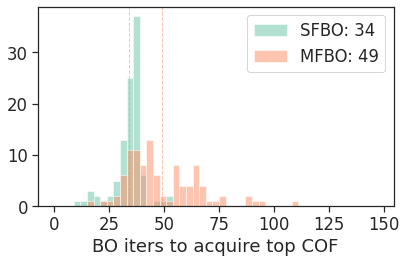

In [7]:
###
#  when, on average, is the top COF located? 
###
mfbo_mean_iter_top_cof = int(np.round(np.mean(mfbo_res['BO_iter_top_cof_acquired'])))
sfbo_mean_iter_top_cof = int(np.round(np.mean(sfbo_res['BO_iter_top_cof_acquired'])))

print("Average iterations to locate top COF - ")
print("MFBO:\t", mfbo_mean_iter_top_cof)
print("SFBO:\t", sfbo_mean_iter_top_cof)


fig = plt.figure()
width = 3
bins = np.array([int(width*i) for i in range(int(nb_iters / width))])

plt.hist(np.array(sfbo_res['BO_iter_top_cof_acquired']), bins=bins,
         label='SFBO: {}'.format(sfbo_mean_iter_top_cof), color="C0", alpha=0.5)

plt.axvline(x=sfbo_mean_iter_top_cof, color="C0", linestyle="--", lw=1, alpha=0.5)

plt.hist(np.array(mfbo_res['BO_iter_top_cof_acquired']), bins=bins,
         label='MFBO: {}'.format(mfbo_mean_iter_top_cof), color="C1", alpha=0.5)

plt.axvline(x=mfbo_mean_iter_top_cof, color="C1", linestyle="--", lw=1, alpha=0.5)


plt.xlabel('BO iters to acquire top COF')
plt.ylabel('')
plt.legend()
plt.tight_layout()
if save_plots:
    plt.savefig("./figs/hist_BO_iter_top_cof_acquired.pdf", format="pdf")
plt.show()

SFBO
2
53
MFBO
5
110


/home/ng/.local/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ng/.local/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/ng/.local/lib/python3.8/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ng/.local/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ng/.local/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/ng/.local/lib/python3.8/site-packages/numpy/core/_methods.p

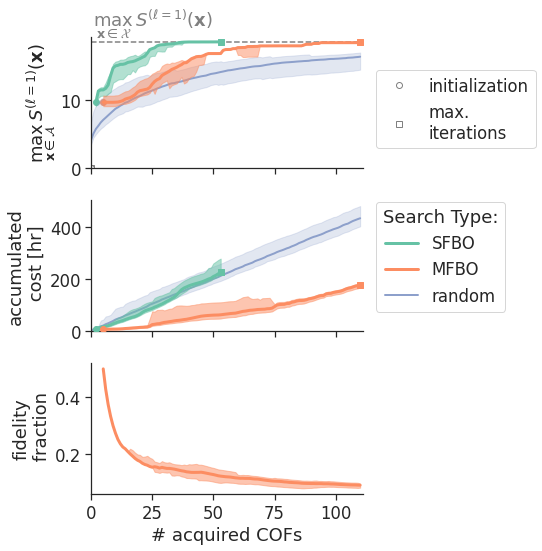

In [8]:
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(8, 8))  
markers = dict({0 : '+', 1: 'x'})

for i, res, search_type in zip([0, 1], [sfbo_res, mfbo_res], ["SFBO", "MFBO"]):
    # color
    color = "C{}".format(i)
    
    # important indexes
    print(search_type)
    iter_start = nb_COFs_initialization * (i + 1) - 1 # i + 1 is convenient hack :)
    print(iter_start)
    iter_top_cof_acquired = np.max(res['BO_iter_top_cof_acquired'])
    print(iter_top_cof_acquired)
    
    iter_range = np.array(range(nb_iters)) # range(iter_start, nb_iters)
    
    ###
    #  get distributions 
    ###
    # y_maxes
    y_max_mu, y_max_sig_bot, y_max_sig_top = get_distribution(res['y_max_acquired'], maxes=True)
    # accumulated_cost
    acc_cost_mu, acc_cost_sig_bot, acc_cost_sig_top = get_distribution(res['accumulated_cost'])
    
    ###
    #  accumulated cost
    ###
    ax[1].plot(iter_range[iter_start:iter_top_cof_acquired+1], 
               acc_cost_mu[iter_start:iter_top_cof_acquired+1], 
               label=search_type, 
               color=color, zorder=10)
    ax[1].fill_between(iter_range[iter_start:iter_top_cof_acquired+1],
                       acc_cost_mu[iter_start:iter_top_cof_acquired+1] - 
                                   acc_cost_sig_bot[iter_start:iter_top_cof_acquired+1],
                       acc_cost_mu[iter_start:iter_top_cof_acquired+1] + 
                                   acc_cost_sig_top[iter_start:iter_top_cof_acquired+1],
                       alpha=0.5, color=color, zorder=5)
    # start and stop
    ax[1].scatter([iter_start], [acc_cost_mu[iter_start]], color=color, marker="o", zorder=100)
    ax[1].scatter([iter_top_cof_acquired], [acc_cost_mu[iter_top_cof_acquired]], 
                  color=color, marker="s", zorder=100)
    
    ###
    #  search efficiency curves
    ###    
    ax[0].plot(iter_range[iter_start:iter_top_cof_acquired+1], 
               y_max_mu[iter_start:iter_top_cof_acquired+1], 
               color=color, linestyle="-", zorder=10)
    ax[0].fill_between(iter_range[iter_start:iter_top_cof_acquired+1], 
                   y_max_mu[iter_start:iter_top_cof_acquired+1] - 
                                       y_max_sig_bot[iter_start:iter_top_cof_acquired+1], 
                   y_max_mu[iter_start:iter_top_cof_acquired+1] + 
                                       y_max_sig_top[iter_start:iter_top_cof_acquired+1],
                   alpha=0.5, color=color, zorder=5)
    # start and stop
    ax[0].scatter([iter_start], [y_max_mu[iter_start]], 
                  label='initialization',
                  color=color, marker="o")
    ax[0].scatter([iter_top_cof_acquired], y_max_mu[iter_top_cof_acquired+1], 
                  label='square', 
                  color=color, marker="s", zorder=100)
    
    ###
    #  fidelity fraction
    ### 
    if search_type == "MFBO":
        # get dist.
        fid_frac_mu, fid_frac_sig_bot, fid_frac_sig_top = get_distribution(res['fidelity_fraction'])
        # plot
        ax[2].plot(iter_range[iter_start:iter_top_cof_acquired+1],
                   fid_frac_mu[iter_start:iter_top_cof_acquired+1], 
                   color=color)
        ax[2].fill_between(iter_range[iter_start:iter_top_cof_acquired+1],
                           fid_frac_mu[iter_start:iter_top_cof_acquired+1] - 
                                   fid_frac_sig_bot[iter_start:iter_top_cof_acquired+1],
                           fid_frac_mu[iter_start:iter_top_cof_acquired+1] + 
                                   fid_frac_sig_top[iter_start:iter_top_cof_acquired+1], 
                           alpha=0.5, color=color)

###
#  random search (SFBO, l=1)
###
iter_stop = np.max(mfbo_res['BO_iter_top_cof_acquired']) + 1
# y_maxes
ax[0].plot(range(iter_stop), random_search_res['y_rs_max_mu'][:iter_stop], 
           lw=2, color="C2", zorder=2)

ax[0].fill_between(range(iter_stop), 
                   random_search_res['y_rs_max_mu'][:iter_stop] - 
                   random_search_res['y_rs_max_sig_bot'][:iter_stop], 
                   random_search_res['y_rs_max_mu'][:iter_stop] + 
                   random_search_res['y_rs_max_sig_top'][:iter_stop], 
                   alpha=0.25, color="C2", zorder=1)
# accumulated cost
acc_cost_mu, acc_cost_sig_bot, acc_cost_sig_top = get_distribution(random_search_res['accumulated_cost'])
ax[1].plot(range(iter_stop), acc_cost_mu[:iter_stop], 
           label="random", lw=2, color="C2", zorder=2)

ax[1].fill_between(range(iter_stop), 
                   acc_cost_mu[:iter_stop] - acc_cost_sig_bot[:iter_stop], 
                   acc_cost_mu[:iter_stop] + acc_cost_sig_top[:iter_stop], 
                   alpha=0.25, color="C2", zorder=1)

###  
#  global maximum
###
ax[0].axhline(y=max(y[1]), color="gray", ls="--", lw=1.5)
ax[0].text(1.0, max(y[1]) + 2.5, 
           r"$\max_{\mathbf{x} \in \mathcal{X}}\, S^{(\ell=1)}(\mathbf{x})$", 
           color="gray")

###
#  axis settings
###
# search efficiency 
ax[0].set_xlim(xmin=0, xmax=iter_stop)
ax[0].set_ylim(ymin=0)
ax[0].set_ylabel(r'$\max_{\mathbf{x} \in \mathcal{A}}\, S^{(\ell=1)}(\mathbf{x})$')
# dummy plots for legend
p_empty_cir = ax[0].plot([0], marker='o', linestyle='none', 
                          markerfacecolor='none', markeredgecolor='grey', label='initialization')
p_empty_sqr = ax[0].plot([0], marker='s', linestyle='none', 
                          markerfacecolor='none', markeredgecolor='grey', label='max.\niterations')
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend([handles[0], handles[1]], [labels[0], labels[1]], loc=(1.05, 0.15))

# accumulated cost
ax[1].set_ylim(ymin=0)
ax[1].set_ylabel("accumulated\n cost [hr]")
ax[1].legend(title="Search Type:", loc=(1.05, 0.15))

# fidelity fraction
ax[2].set_xlabel("# acquired COFs")
ax[2].set_ylabel("fidelity\n fraction")

plt.tight_layout()
sns.despine()
if save_plots:
    plt.savefig("./figs/FidFrac_Cost_and_Search_Efficiency_with_averages.pdf", format="pdf")
plt.show()

## Pirinciple Component Analysis

In [9]:
pca = PCA(n_components=2)
pca.fit(X)
X_2D = pca.transform(X)

###
#  test point
###
a = torch.from_numpy(np.array([X[:, i].mean() for i in range(X.size()[1])]))
X_center = pca.transform(a.reshape(1, -1))

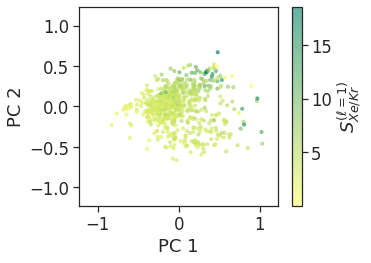

In [10]:
cmap_name = cm.summer_r # sequential colormap (reversed)

###
#  low dimensional (PCA) visualization of the entire dataset
###
fig = plt.figure()
plt.scatter(X_2D[:, 0], X_2D[:, 1], c=y[1], cmap=cmap_name, s=10, alpha=0.6)

###
#  axis commands
###
ax_lim = max([np.max(X_2D), abs(np.min(X_2D))]) + 0.2
plt.xlim([-ax_lim, ax_lim])
plt.ylim([-ax_lim, ax_lim])

plt.xticks()
plt.yticks()
plt.xlabel('PC 1')
plt.ylabel('PC 2')
cb = plt.colorbar(fraction=0.03, pad=0.04)
cb.set_label(label="$S^{(\ell=1)}_{Xe/Kr}$")

plt.gca().set_aspect('equal', 'box')

plt.tight_layout()
# if save_plots:
#     plt.savefig("./figs/PCA_feature_space_colored_by_GCMC_Selectivity.pdf", dpi=600, format="pdf")
plt.show()

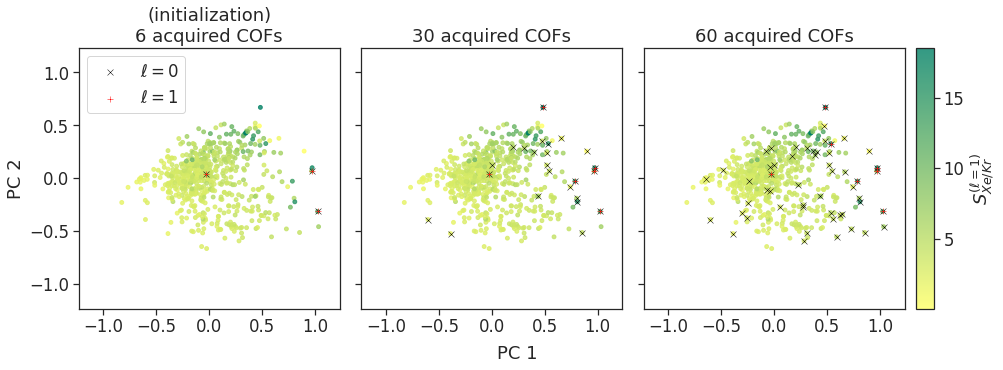

In [11]:
nb_acquired = [2*nb_COFs_initialization, 30, 60]

# set up figure and image grid
fig = plt.figure(figsize=[3*6.4 + 0.5, 4.8])

grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(1, 3),
                 axes_pad=0.3,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.15,
                 )

# add data to image grid
for (i, nb), ax in zip(enumerate(nb_acquired), grid):
    acq = mfbo_res['acquired_set'][0][:nb]
    lf_acq = acq[acq[:, 0] == 0, :] # low-fidelity
    hf_acq = acq[acq[:, 0] == 1, :] # high-fidelity
    assert len(lf_acq) + len(hf_acq) == len(acq)
    ###
    #  plot PCA for all COFs
    ###
    pca_base = ax.scatter(X_2D[:, 0], X_2D[:, 1], c=y[1], cmap=cmap_name,
                             facecolor='none', s=15, alpha=0.8) 
    
    ### 
    # plot center of feature space and transformed point
    ###
#     if i == 0:
#         ax.scatter(X_center[:, 0], X_center[:, 1], color="b", marker="*", s=30)
        
    ###
    #  indicate acquired points at the given iteration
    ###
    # low-fidelity
    ax.scatter(X_2D[lf_acq[:nb, 1], 0], X_2D[lf_acq[:nb, 1], 1], 
                  label="$\ell=0$",
                  color='k', marker='x', s=35, lw=0.5) 
    # high-fidelity
    ax.scatter(X_2D[hf_acq[:nb, 1], 0], X_2D[hf_acq[:nb, 1], 1], 
               label="$\ell=1$",
               color='r', marker='+', s=35, lw=0.5, zorder=1)
    

    
    # subplot titles
    if i == 0:
        ax.set_title('(initialization)\n{} acquired COFs'.format(nb_acquired[i]))
    else:
        ax.set_title('{} acquired COFs'.format(nb_acquired[i]))
        
    ax.tick_params(axis='x')
    ax.set_aspect('equal', 'box')

###
#  colorbar
###
cb = ax.cax.colorbar(pca_base)
cb.set_label(label="$S^{(\ell=1)}_{Xe/Kr}$")

###
#  axis commands
###
grid[0].legend()
grid[0].set_ylabel('PC 2')
fig.text(0.52, -0.02, 'PC 1', ha='center')

grid[0].set_xlim([-ax_lim, ax_lim])
grid[0].set_ylim([-ax_lim, ax_lim])


if save_plots:
    plt.savefig("./figs/MFBO_PCA_dynamics.pdf", bbox_inches="tight", dpi=600, format="pdf")
plt.show()